In [1]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from model.model import unet
import torch
import torch.nn as nn
print(torch.cuda.device_count())
from scipy.signal import butter, filtfilt
import math

1


Filtering and plotting an example of earthquake data and car data

In [2]:
# Define highpass filter
def highpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

# Apply highpass filter to the data
fs = 200  # Sampling frequency (Hz)
cutoff = 1  # Cutoff frequency (Hz)

In [3]:
eq_file_path = "/1-fnp/petasaur/p-jbod1/rainier/2024/02/07/decimator_2024-02-07_19.11.00_UTC.h5"
car_file_path = "/1-fnp/petasaur/p-jbod1/rainier/2023/08/28/decimator_2023-08-28_01.25.00_UTC.h5"

# car_file_paths = [
#     "/1-fnp/petasaur/p-jbod1/rainier/2023/08/28/decimator_2023-08-28_01.25.00_UTC.h5",
#     # "/1-fnp/petasaur/p-jbod1/rainier/2023/08/27/decimator_2023-08-27_20.07.00_UTC.h5",
#     # "/1-fnp/petasaur/p-jbod1/rainier/2023/09/02/decimator_2023-09-02_17.46.00_UTC.h5",
#     # "/1-fnp/petasaur/p-jbod1/rainier/2023/09/02/decimator_2023-09-02_15.14.00_UTC.h5",
#     # "/1-fnp/petasaur/p-jbod1/rainier/2023/09/12/decimator_2023-09-12_16.28.00_UTC.h5",
#     # "/1-fnp/petasaur/p-jbod1/rainier/2023/09/12/decimator_2023-09-12_18.56.00_UTC.h5",
#     # "/1-fnp/petasaur/p-jbod1/rainier/2023/09/13/decimator_2023-09-13_19.49.00_UTC.h5",
#     # "/1-fnp/petasaur/p-jbod1/rainier/2023/09/14/decimator_2023-09-14_18.28.00_UTC.h5",
#     # "/1-fnp/petasaur/p-jbod1/rainier/2023/09/16/decimator_2023-09-16_19.38.00_UTC.h5",
#     # "/1-fnp/petasaur/p-jbod1/rainier/2023/09/16/decimator_2023-09-16_20.10.00_UTC.h5",
# ]

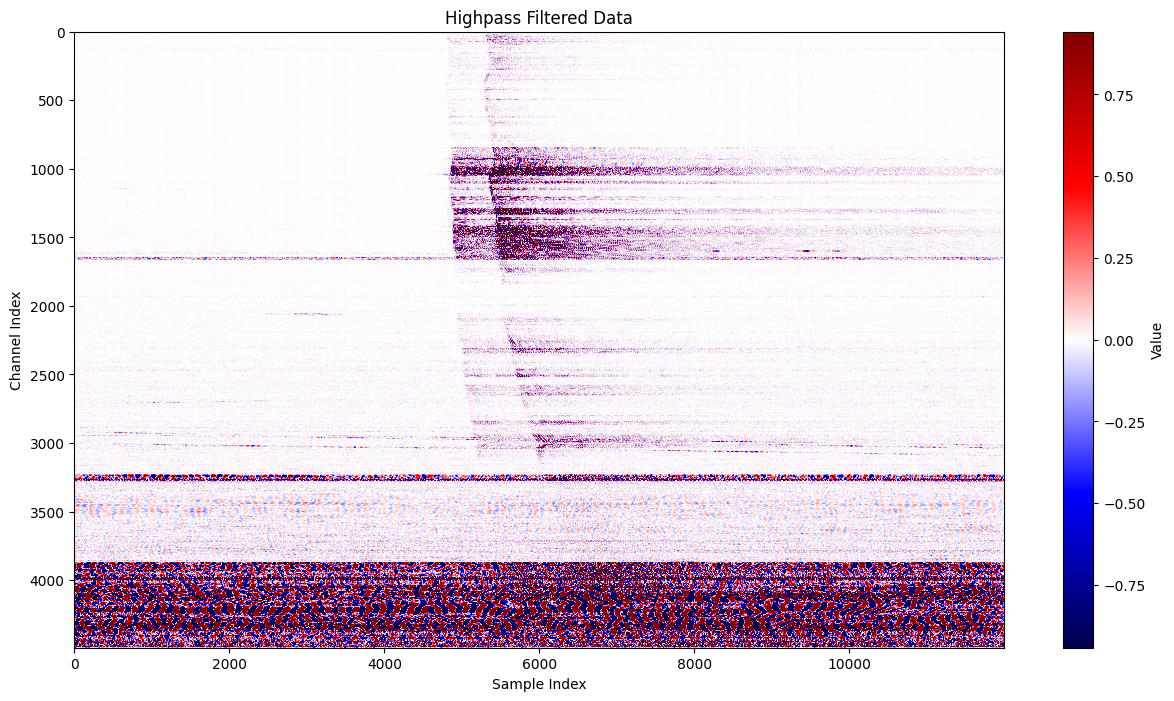

In [4]:
with h5py.File(eq_file_path, 'r', locking=False) as f:
    eq_data = f['Acquisition/Raw[0]/RawData'][:]
    
# Apply highpass filter
filtered_eq_data = highpass_filter(eq_data, cutoff, fs)
filtered_eq_data_max = np.percentile(np.abs(filtered_eq_data), 90)
 
# Plot the filtered data
plt.figure(figsize=(15, 8))
plt.imshow(filtered_eq_data.T, aspect='auto', cmap='seismic', vmin=-filtered_eq_data_max, vmax=filtered_eq_data_max)
plt.colorbar(label='Value')
plt.title("Highpass Filtered Data")
plt.xlabel("Sample Index")
plt.ylabel("Channel Index")
plt.show()

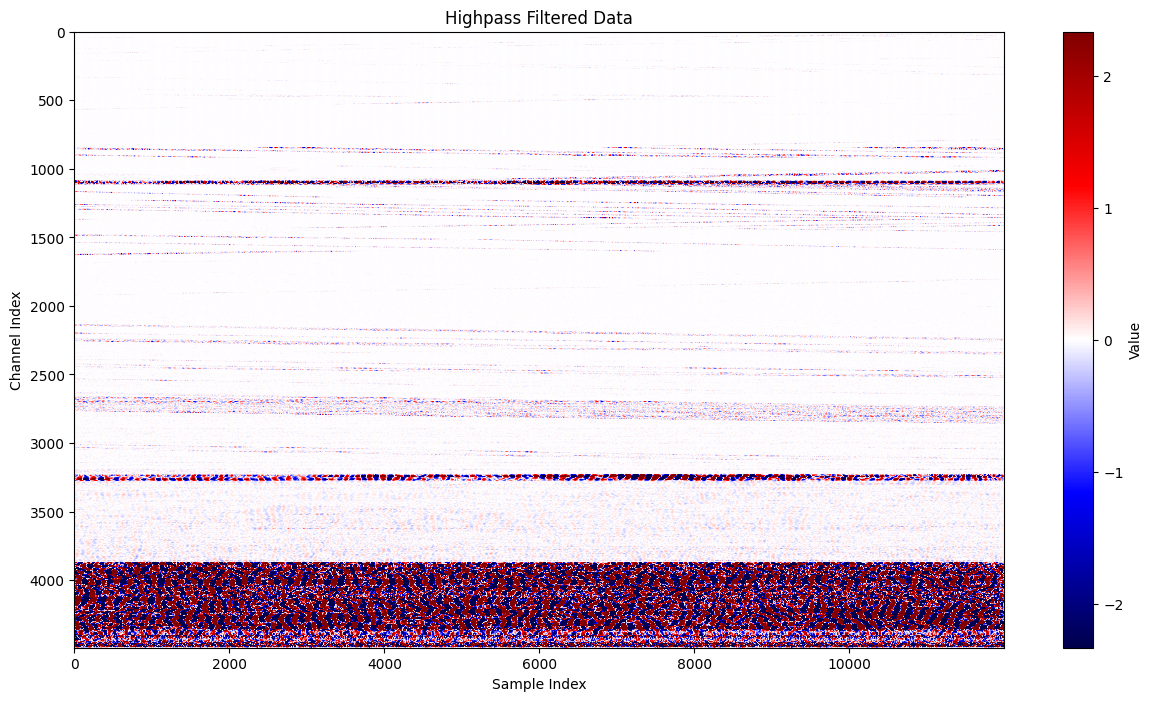

In [5]:
with h5py.File(car_file_path, 'r', locking=False) as f:
    car_data = f['Acquisition/Raw[0]/RawData'][:]
    
# Apply highpass filter
filtered_car_data = highpass_filter(car_data, cutoff, fs)
filtered_car_data_max = np.percentile(np.abs(filtered_car_data), 90)
 
# Plot the filtered data
plt.figure(figsize=(15, 8))
plt.imshow(filtered_car_data.T, aspect='auto', cmap='seismic', vmin=-filtered_car_data_max, vmax=filtered_car_data_max)
plt.colorbar(label='Value')
plt.title("Highpass Filtered Data")
plt.xlabel("Sample Index")
plt.ylabel("Channel Index")
plt.show()

Overlaying car data on earthquake data

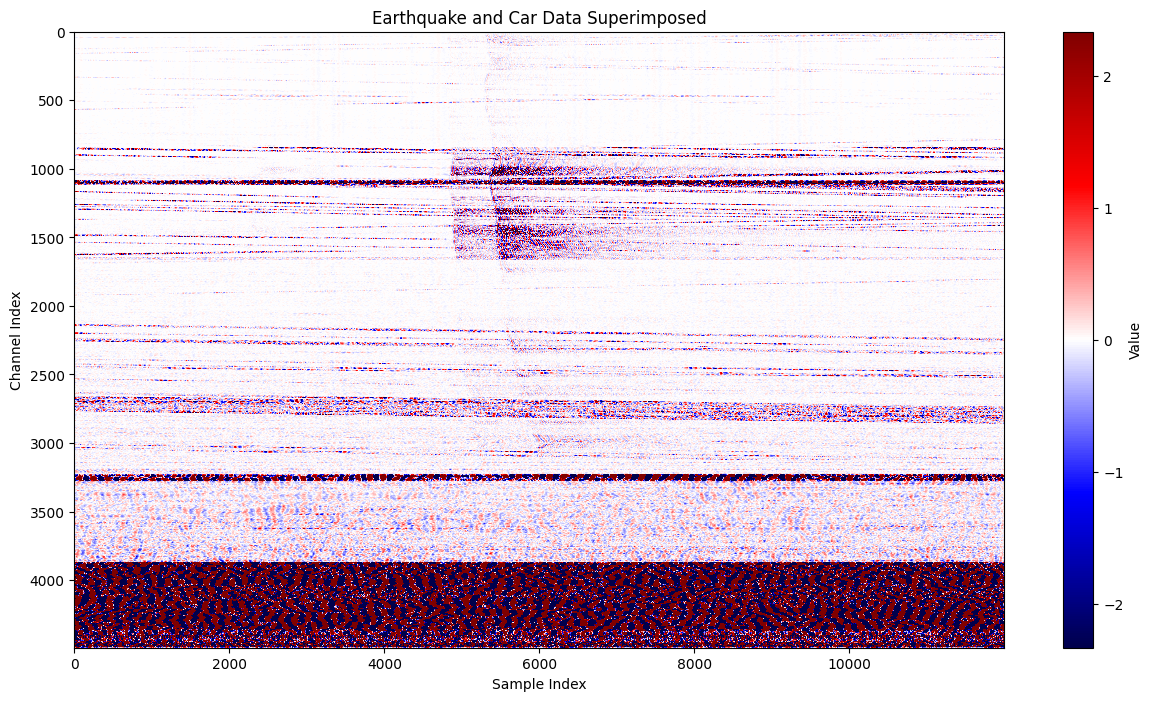

In [6]:
max_val = max(np.percentile(np.abs(filtered_eq_data), 90), np.percentile(np.abs(filtered_car_data), 90))

plt.figure(figsize=(15, 8))
plt.imshow(filtered_eq_data.T + 3*filtered_car_data.T, aspect='auto', cmap='seismic', vmin=-filtered_car_data_max, vmax=filtered_car_data_max)
plt.colorbar(label='Value')
plt.title("Earthquake and Car Data Superimposed")
plt.xlabel("Sample Index")
plt.ylabel("Channel Index")
plt.show()

Getting more earthquake data from Mt. Rainier (08/2023 - 11/2023)

In [7]:
# Load the CSV file
file_path = '/home/ajm76/FM_Denoising_DAS/data/mt_rainier.csv'
data = pd.read_csv(file_path)

# Initialize an empty list to store filenames
eq_files = []
car_files = []
other_files = []

# Filter rows based on the last column ('DAS_visibility') 
eq_files = data[data['DAS_visibility'] == 'y']['matched_file'].tolist()
car_files = data[data['DAS_visibility'] != 'y']['matched_file'].tolist()
other_files = data[data['DAS_visibility'] == 'm']['matched_file'].tolist()

print(len(eq_files))
print(len(car_files))
print(len(other_files))

168
539
15


(12000, 4494)


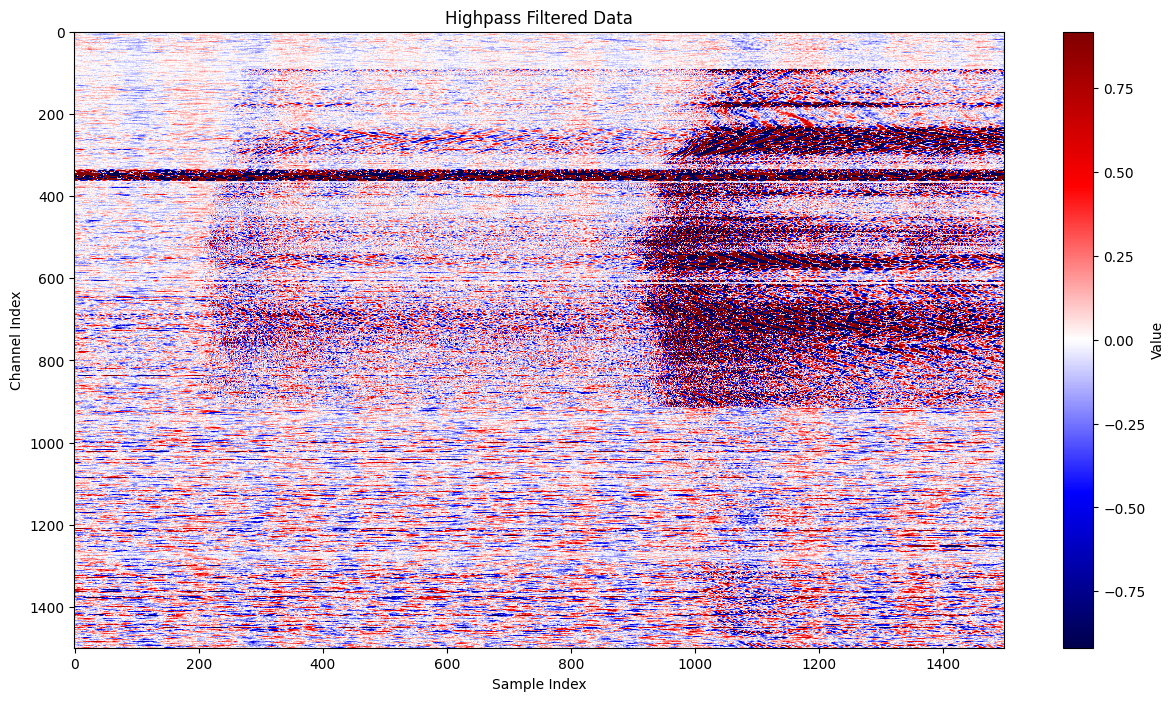

In [8]:
file_path = "/1-fnp/petasaur/p-jbod1/rainier/2023/08/25/decimator_2023-08-25_07.23.00_UTC.h5"

with h5py.File(file_path, 'r', locking=False) as f:
    data = f['Acquisition/Raw[0]/RawData'][:]

print(data.shape)

# Apply highpass filter
filtered_data = highpass_filter(data, cutoff, fs)
data = filtered_data[3600:5100, 750:2250]
# data = filtered_data
data_norm = (data - np.mean(data)) / np.std(data)
data_max = np.percentile(np.abs(data_norm), 90)
 
# Plot the filtered data
plt.figure(figsize=(15, 8))
plt.imshow(data_norm.T, aspect='auto', cmap='seismic', vmin=-data_max, vmax=data_max)
plt.colorbar(label='Value')
plt.title("Highpass Filtered Data")
plt.xlabel("Sample Index")
plt.ylabel("Channel Index")
plt.show()

In [ ]:
# # file_path = '/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_11_11.hdf5'
# file_path = '/data/wsd04/GCI_DAS/KKFLStill2024_02_16.hdf5'

# # Load the data
# with h5py.File(file_path, 'r', locking=False) as f:
#     data = f['Acquisition/Raw[0]/RawData'][:]

# # Get dimensions of data
# data = f['Acquisition/Raw[0]/RawData'][:]
# data_time = f['Acquisition/Raw[0]/RawDataTime'][:]
# data_sample_count = f['Acquisition/Raw[0]/RawDataSampleCount'][:]

# print(f"Data shape: {data.shape}")
# print(f"DataTime shape: {data_time.shape}")
# print(f"DataSampleCount shape: {data_sample_count.shape}")